**请填写你的姓名与学号**

In [2]:
name="朱永山"
student_id="23009200687"

# 使用神经网络进行手写字符识别

在本次实验中，你将学会如何实现神经网络的误差反传训练算法，并应用它进行手写数字识别。

In [4]:
# 查看当前挂载的数据集目录
!ls

NN_data.mat            environment.yml        nn-backpropagation.png
NN_weights.mat         my-data-array.png      nn-representation.png
data-array.png         neural-networks.ipynb


## 数据介绍

本次练习所用的数据集有5000个训练样本，每个样本对应于20x20大小的灰度图像。这些训练样本包括了9-0共十个数字的手写图像。这些样本中每个像素都用浮点数表示。加载得到的数据中，每幅图像都被展开为一个400维的向量，构成了数据矩阵中的一行。完整的训练数据是一个5000x400的矩阵，其每一行为一个训练样本（数字的手写图像）。数据中，对应于数字"0"的图像被标记为"10"，而数字"1"到"9"按照其自然顺序被分别标记为"1"到"9"。数据集保存在`NN_data.mat`.

![image](./data-array.png)


## 模型表示

我们准备训练的神经网络是一个三层的结构，一个输入层，一个隐层以及一个输出层。由于我们训练样本（图像）是20x20的，所以输入层单元数为400（不考虑额外的偏置项，如果考虑单元个数需要+1）。在我们的程序中，数据会被加载到变量<span> $X$ </span> 和<span> $y$ </span>里。

本项练习提供了一组训练好的网络参数<span> $(\Theta^{(1)}, \Theta^{(2)})$ </span>。这些数据存储在数据文件 `NN_weights.mat`，在程序中被加载到变量 `Theta1` 与 `Theta2` 中。参数的维度对应于第二层有25个单元、10个输出单元（对应于10个数字 的类别）的网络。

![image](./nn-representation.png)


In [7]:
import numpy as np
import scipy.io as sio
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt

In [8]:
def display_data(data, img_width=20):
    """将图像数据 data 按照矩阵形式显示出来"""
    plt.figure()
    # 计算数据尺寸相关数据
    n_rows, n_cols = data.shape
    img_height = n_cols // img_width

    # 计算显示行数与列数
    disp_rows = int(np.sqrt(n_rows))
    disp_cols = (n_rows + disp_rows - 1) // disp_rows

    # 图像行与列之间的间隔
    pad = 1
    disp_array = np.ones((pad + disp_rows*(img_height + pad),
                          pad + disp_cols*(img_width + pad)))

    idx = 0
    for row in range(disp_rows):
        for col in range(disp_cols):
            if idx > m:
                break
            # 复制图像块
            rb = pad + row*(img_height + pad)
            cb = pad + col*(img_width + pad)
            disp_array[rb:rb+img_height, cb:cb+img_width] = data[idx].reshape((img_height, -1), order='F')
            # 获得图像块的最大值，对每个训练样本分别归一化
            max_val = np.abs(data[idx].max())
            disp_array[rb:rb+img_height, cb:cb+img_width] /= max_val
            idx += 1

    plt.imshow(disp_array)

    plt.gray()
    plt.axis('off')
    plt.savefig('my-data-array.png', dpi=150)
    plt.show()

## 前向传播与代价函数

现在你需要实现神经网络的代价函数及其梯度。首先需要使得函数 `nn_cost_function` 能够返回正确的代价值。

神经网络的代价函数（不包括正则化项）的定义为：
$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} -y_k^{(i)} \log\left((h_{\theta}(x^{(i)}))_k\right)$$
其中<span> $h_{\theta}(x^{(i)})$ </span> 的计算如神经网络结构图所示，<span> $K=10$ </span>是 所有可能的类别数。这里的<span> $y$ </span>使用了one-hot 的表达方式。

运行程序，使用预先训练好的网络参数，确认你得到的代价函数是正确的。（正确的代价约为0.287629）。

## 代价函数的正则化

神经网络包括正则化项的代价函数为: </br>
$$J(\theta) = \frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} -y_k^{(i)} \log\left((h_{\theta}(x^{(i)}))_k\right) + \frac{\lambda}{2m} \left[\sum_{j=1}^{25} \sum_{k=1}^{400} (\Theta_{j,k}^{(1)})^2 +\sum_{j=1}^{10} \sum_{k=1}^{25} (\Theta_{j,k}^{(2)})^2 \right] $$


注意在上面式子中，正则化项的加和形式与练习中设定的网络结构一致。但是你的代码实现要保证能够用于任意大小的神经网络。
此外，还需要注意，对应于偏置项的参数不能包括在正则化项中。对于矩阵 `Theta1` 与 `Theta2` 而言，这些项对应于矩阵的第一列。

运行程序，使用预先训练好的权重数据，设置正则化系数$\lambda=1$ (`lmb`) 确认你得到的代价函数是正确的。（正确的代价约为0.383770）。

此步练习需要你补充实现 `nn_cost_function` 。

In [12]:
def nn_cost_function(nn_params, *args):
    """神经网络的损失函数"""
    # Unpack parameters from *args
    input_layer_size, hidden_layer_size, num_labels, lmb, X, y = args
    # Unroll weights of neural networks from nn_params
    Theta1 = nn_params[:hidden_layer_size*(input_layer_size + 1)]
    Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size*(input_layer_size + 1):]
    Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

    # 设置变量
    m = X.shape[0]

    # You need to return the following variable correctly
    J = 0.0

    # ====================== 你的代码 ======================
    # assume that the X is a (m,1) matrix
    a_1 = np.hstack(([[1]], X))
    z_2 = Theta1.dot(a_1)
    z_2 = sigmoid(z_2)
    a_2 = np.hstack(([[1]], z_2))
    z_3 = Theta2.dot(a_2)
    a_3 = sigmoid(z_3)  # h theta x
    entropy = np.log(a_3)
    left = -y.dot(entropy) / m
    right =  (lmb/2*m)*(np.sum(Theta1**2) + np.sum(Theta2**2))
    J = left + right
    # ======================================================
    return J


## 误差反传训练算法 (Backpropagation)

![image](./nn-backpropagation.png)

现在你需要实现误差反传训练算法。误差反传算法的思想大致可以描述如下。对于一个训练样本<span> $(x^{(t)}, y^{(t)})$ </span>，我们首先使用前向传播计算网络中所有单元（神经元）的激活值（activation），包括假设输出<span> $h_{\Theta}(x)$ </span>。那么，对于第<span> $l$ </span>层的第<span> $j$ </span>个节点，我们期望计算出一个“误差项”<span> $\delta_{j}^{(l)}$ </span>用于衡量该节点对于输出的误差的“贡献”。

对于输出节点，我们可以直接计算网络的激活值与真实目标值之间的误差。对于我们所训练的第3层为输出层的网络，这个误差定义了<span> $\delta_{j}^{(3)}$ </span>。对于隐层单元，需要根据第<span> $l+1$ </span>层的节点的误差的加权平均来计算<span> $\delta_{j}^{(l)}$ </span>。

下面是误差反传训练算法的细节（如图3所示）。你需要在一个循环中实现步骤1至4。循环的每一步处理一个训练样本。第5步将累积的梯度除以<span> $m$ </span>以得到神经网络代价函数的梯度。

1.  设输入层的值<span> $a^{(1)}$ </span>为第<span> $t$ </span>个训练样本<span> $x^{(t)}$ </span>。执行前向传播，计算第2层与第3层各节点的激活值(<span> $z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)}$ </span>)。注意你需要在<span> $a^{(1)}$ </span>与<span> $a^{(2)}$ </span>增加一个全部为 +1 的向量，以确保包括了偏置项。在 `numpy` 中可以使用函数 `ones` ， `hstack`, `vstack` 等完成（向量化版本）。
2.  对第3层中的每个输出单元<span> $k$ </span>，计算

    $$ \delta_{k}^{(3)} = a_{k}^{(3)} - y_k $$
    其中<span> $y_k \in \{0, 1\}$ </span>表示当前训练样本是否是第<span> $k$ </span>类。

3.  对隐层<span> $l=2$ </span>, 计算

	$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} .* g^{\prime} (z^{(2)}) $$
	
    其中$g^{\prime}$ 表示 Sigmoid 函数的梯度， `.*` 在 `numpy` 中是通 常的逐个元素相乘的乘法，矩阵乘法应当使用 `numpy.dot` 函数。

4.  使用下式将当前样本梯度进行累加：
	$$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^T $$
    在 `numpy` 中，数组可以使用 `+=` 运算。

5.  计算神经网络代价函数的（未正则化的）梯度，
	$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} $$

这里，你需要（部分）完成函数 `nn_grad_function` 。程序将使用函数 `check_nn_gradients` 来检查你的实现是否正确。在使用循环的方式完成函数 `nn_grad_function` 后，建议尝试使用向量化的方式重新实现这个函数。



## 神经网络的正则化

你正确实现了误差反传训练算法之后，应当在梯度中加入正则化项。

假设你在误差反传算法中计算了<span> $\Delta_{ij}^{(l)}$ </span>，你需要增加的正则化项为

$$\frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} \qquad \text{for } j = 0
\frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} \qquad \text{for } j \geq 1 $$

注意你不应该正则化<span> $\Theta^{(l)}$ </span>的第一列，因其对应于偏置项。

此步练习需要你补充实现函数 `nn_grad_function` 。


In [14]:
def nn_grad_function(nn_params, *args):
    """神经网络的损失函数梯度计算 """
    
    # 获得参数信息
    input_layer_size, hidden_layer_size, num_labels, lmb, X, y = args
    # 得到各个参数的权重值
    Theta1 = nn_params[:hidden_layer_size*(input_layer_size + 1)]
    Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size*(input_layer_size + 1):]
    Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

    # 设置变量
    m = X.shape[0]

    # ====================== 你的代码 =====================
    a_1 = vstack([[1]], X)
    z_2 = Theta1.dot(a_1)
    z_2 = sigmoid(z_2)
    a_2 = vstack([[1]], z_2)
    z_3 = Theta2.dot(a_2)
    a_3 = sigmoid(z_3)  # h theta x
    delta =  a_3 - y
    # 计算Theta1，Theta2的梯度值
    
    # =====================================================
    
    grad = np.hstack((Theta1_grad.flatten(), Theta2_grad.flatten()))
    return grad



## 误差反传训练算法

### `Sigmoid` 函数及其梯度

Sigmoid 函数定义为

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1+\exp(-z)} $$


Sigmoid 函数的梯度可以按照下式进行计算
$$ g^{\prime}(z) = \frac{d}{dz} g(z) = g(z)(1-g(z)) $$
为验证你的实现是正确的，以下事实可供你参考。当<span> $z=0$ </span>是，梯度的精确值为 0.25 。当<span> $z$ </span>的值很大（可正可负）时，梯度值接近于0。

这里，你需要补充完成函数 `sigmoid` 与 `sigmoid_gradient` 。 你需要保证实现的函数的输入参数可以为矢量和矩阵( `numpy.ndarray`)。

### 网络参数的随机初始化

训练神经网络时，使用随机数初始化网络参数非常重要。一个非常有效的随机初始化策略为，在范围<span> $[ -\epsilon_{init}, \epsilon_{init} ]$ </span>内按照均匀分布随机选择参数<span> $\Theta^{(l)}$ </span>的初始值。这里你需要设置<span> $\epsilon_{init} = 0.12$ </span>。这个范围保证了参数较小且训练过程高效。

你需要补充实现函数 `rand_initialize_weigths` 。

对于一般的神经网络，如果第<span> $l$ </span>层的输入单元数为<span> $L_{in}$ </span>，输出单元数为<span> $L_{out}$ </span>，则<span> $\epsilon_{init} = {\sqrt{6}}/{\sqrt{L_{in} + L_{out}}}$ </span>可以做为有效的指导策略。

In [17]:
def sigmoid(z):
    """Sigmoid 函数"""
    return 1.0/(1.0 + np.exp(-np.asarray(z)))

In [19]:
def sigmoid_gradient(z):
    """计算Sigmoid 函数的梯度"""
    g = np.zeros_like(z)
    # ======================　你的代码 ======================
    g = np.matmul(sigmoid(z),(1-sigmoid(z)))
    # =======================================================
    return g

In [21]:
def rand_initialize_weights(L_in, L_out):
    """ 初始化网络层权重参数"""

    # You need to return the following variables correctly
    W = np.zeros((L_out, 1 + L_in))
    # ====================== 你的代码 ======================
    epsilon = 0.12 
    W = np.random.uniform(-epsilon, epsilon, size=W.shape)
    # ======================================================
    return W

In [23]:
def debug_initialize_weights(fan_out, fan_in):
    """Initalize the weights of a layer with
    fan_in incoming connections and
    fan_out outgoing connection using a fixed strategy."""

    W = np.linspace(1, fan_out*(fan_in+1), fan_out*(fan_in+1))
    W = 0.1*np.sin(W).reshape(fan_out, fan_in + 1)
    return W

In [25]:
def compute_numerical_gradient(cost_func, theta):
    """Compute the numerical gradient of the given cost_func
    at parameter theta"""

    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    eps = 1.0e-4
    for idx in range(len(theta)):
        perturb[idx] = eps
        loss1 = cost_func(theta - perturb)
        loss2 = cost_func(theta + perturb)
        numgrad[idx] = (loss2 - loss1)/(2*eps)
        perturb[idx] = 0.0
    return numgrad

## 检查梯度
在神经网络中，需要最小化代价函数<span> $J(\Theta)$ </span>。为了检查梯度计算是否正确，考虑把参数<span> $\Theta^{(1)}$ </span>和<span> $\Theta^{(2)}$ </span>展开为一个长的向量<span> $\theta$ </span>。假设函数<span> $f_i(\theta)$ </span>表示<span> $\frac{\partial}{\partial \theta_i} J(\theta)$ </span>。

令
$$ \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix} \qquad
  \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix} $$

上式中，<span> $\theta^{(i+)}$ </span>除了第<span> $i$ </span>个元素增加了<span> $\epsilon$ </span>之 外，其他元素均与<span> $\theta$ </span>相同。类似的，<span> $\theta^{(i-)}$ </span>中仅第<span> $i$ </span>个元素减少了<span> $\epsilon$ </span>。可以使用数值近似验证<span> $f_i(\theta)$ </span>计算是否正确：
$$f_i(\theta) \approx \frac{J(\theta^{(i+)}) - J(\theta^{(i-)})}{2\epsilon}$$
如果设<span> $\epsilon=10^{-4}$ </span>，通常上式左右两端的差异出现于第4位有效数字之后（经常会有更高的精度）。

在练习的程序代码中，函数 `compute_numerical_gradient` 已经实现，建议你认真阅读该函数并理解其实现原理与方案。

之后，程序将执行 `check_nn_gradients` 函数。该函数将创建一个较小的神经网络用于检测你的误差反传训练算法所计算得到的梯度是否正确。如果你的实现是正确的，你得到的 梯度与数值梯度之后的绝对误差（各分量的绝对值差之和）应当小于<span> $10^{-9}$ </span>。

In [28]:
def check_nn_gradients(lmb=0.0):
    """Creates a small neural network to check the backgropagation
    gradients."""
    input_layer_size, hidden_layer_size = 3, 5
    num_labels, m = 3, 5

    Theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    Theta2 = debug_initialize_weights(num_labels, hidden_layer_size)

    X = debug_initialize_weights(m, input_layer_size - 1)
    y = np.array([1 + (t % num_labels) for t in range(m)])
    nn_params = np.hstack((Theta1.flatten(), Theta2.flatten()))

    cost_func = lambda x: nn_cost_function(x,
                                           input_layer_size,
                                           hidden_layer_size,
                                           num_labels, lmb, X, y)
    grad = nn_grad_function(nn_params,
                            input_layer_size, hidden_layer_size,
                            num_labels, lmb, X, y)
    numgrad = compute_numerical_gradient(cost_func, nn_params)
    print(np.vstack((numgrad, grad)).T, np.sum(np.abs(numgrad - grad)))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)')

In [30]:
def predict(Theta1, Theta2, X):
    """模型预测"""
   
    m = X.shape[0]
    # num_labels = Theta2.shape[0]

    p = np.zeros((m,1), dtype=int)
    # ====================== 你的代码============================
    
    # 神经网络模型预测
    
    # ============================================================
    # print(h1.shape, h2.shape)
    p = np.argmax(h2, axis=1) + 1.0
    return p


In [32]:
# Parameters
input_layer_size = 400          # 20x20 大小的输入图像，图像内容为手写数字
hidden_layer_size = 25          # 25 hidden units
num_labels = 10                 # 10 类标号 从1到10

## 加载数据集

Loading and Visualizing Data...


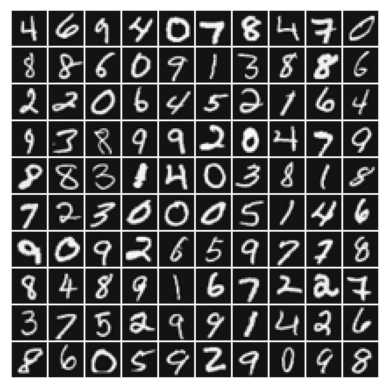

In [35]:
# =========== 第一部分 ===============
# 加载训练数据
print("Loading and Visualizing Data...")
data = sio.loadmat('NN_data.mat')
X, y = data['X'], data['y']

m = X.shape[0]

# 随机选取100个数据显示
rand_indices = np.array(range(m))
np.random.shuffle(rand_indices)
X_sel = X[rand_indices[:100]]

display_data(X_sel)

## 加载神经网络模型的权重

In [38]:
# =========== 第二部分 ===============
print('Loading Saved Neural Network Parameters ...')

# Load the weights into variables Theta1 and Theta2
data = sio.loadmat('NN_weights.mat')
Theta1, Theta2 = data['Theta1'], data['Theta2']

# print Theta1.shape, (hidden_layer_size, input_layer_size + 1)
# print Theta2.shape, (num_labels, hidden_layer_size + 1)

Loading Saved Neural Network Parameters ...


In [124]:
# ================ Part 3: Compute Cost (Feedforward) ================

#  To the neural network, you should first start by implementing the
#  feedforward part of the neural network that returns the cost only. You
#  should complete the code in nnCostFunction.m to return cost. After
#  implementing the feedforward to compute the cost, you can verify that
#  your implementation is correct by verifying that you get the same cost
#  as us for the fixed debugging parameters.
#
#  We suggest implementing the feedforward cost *without* regularization
#  first so that it will be easier for you to debug. Later, in part 4, you
#  will get to implement the regularized cost.

print('Feedforward Using Neural Network ...')

# Weight regularization parameter (we set this to 0 here).
lmb = 0.0

nn_params = np.hstack((Theta1.flatten(), Theta2.flatten()))
J = nn_cost_function(nn_params,
                     input_layer_size, hidden_layer_size,
                     num_labels, lmb, X, y)

print('Cost at parameters (loaded from PRML_NN_weights): %f ' % J)
print('(this value should be about 0.287629)')

Feedforward Using Neural Network ...
Cost at parameters (loaded from PRML_NN_weights): -851.766765 
(this value should be about 0.287629)


In [132]:
Theta1

array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
        -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
       [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
        -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
       [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
        -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
       ...,
       [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
         2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
       [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
        -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
       [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
        -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]])

In [160]:
a_1 = np.hstack((np.ones([5000, 1]), X))
# Theta1(25, 401)
# a_1(5000, 401)
# Theta2(10, 26)
z_2 = Theta1.dot(a_1.T)    ## 25,5000   
a_2 = sigmoid(z_2)
a_2 = np.vstack((np.ones([1, 5000]) , z_2))
z_3 = Theta2.dot(a_2)
a_3 = sigmoid(z_3) # (10,5000) matrix
entropy = np.log(a_3)
y.shape   # (5000,1)
left = np.sum(entropy.dot(-y)) / m
left
right =  (lmb/(2*m))*(np.sum(Theta1**2) + np.sum(Theta2**2))
J = left + right
print(J)
print(entropy.shape)
print(y.shape)
print(np.matmul(entropy, y))

-37792.892588207564
(10, 5000)
(5000, 1)
[[-929852.62243326]
 [-312661.71280003]
 [-234673.00350879]
 [-693421.10554392]
 [-632097.9633195 ]
 [-413958.29816305]
 [-710151.37550756]
 [  -2047.93237893]
 [-100787.02369871]
 [-229182.78799132]]


In [122]:
def nn_cost_function(nn_params, *args):
    """神经网络的损失函数"""
    # Unpack parameters from *args
    input_layer_size, hidden_layer_size, num_labels, lmb, X, y = args
    # Unroll weights of neural networks from nn_params
    Theta1 = nn_params[:hidden_layer_size*(input_layer_size + 1)]
    Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size*(input_layer_size + 1):]
    Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

    # 设置变量
    m = X.shape[0]

    # You need to return the following variable correctly
    J = 0.0

    # ====================== 你的代码 ======================
    # assume that the X is a (m,1) matrix
    b_1 = np.ones([5000, 1])
    a_1 = np.hstack((b, X))
    z_2 = Theta1.dot(a_1.T)
    b_1 = np.ones([1, 5000])
    z_2 = np.vstack((b_1, z_2))
    z_3 = Theta2.dot(z_2)
    a_3 = sigmoid(z_3) # (10,5000) matrix
    entropy = np.log(a_3)
    left = np.sum(entropy.dot(y) /m)
    right =  (lmb/(2*m))*(np.sum(Theta1**2) + np.sum(Theta2**2))
    J = left + right
    # ======================================================
    return J


In [ ]:
# =============== Part 4: Implement Regularization ===============
print('Checking Cost Function (w/ Regularization) ... ')
lmb = 1.0

J = nn_cost_function(nn_params,
                     input_layer_size, hidden_layer_size,
                     num_labels, lmb, X, y)

print('Cost at parameters (loaded from PRML_NN_weights): %f ' % J)
print('(this value should be about 0.383770)')

In [ ]:
# ================ Part 5: Sigmoid Gradient  ================
print('Evaluating sigmoid gradient...')

g = sigmoid_gradient([1, -0.5, 0, 0.5, 1])
print('Sigmoid gradient evaluated at [1 -0.5 0 0.5 1]:  ', g)

## 神经网络参数初始化

In [ ]:
#  ================ Part 6: Initializing Pameters ================
print('Initializing Neural Network Parameters ...')
initial_Theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.hstack((initial_Theta1.flatten(),
                               initial_Theta2.flatten()))

In [ ]:

# =============== Part 7: Implement Backpropagation ===============
print('Checking Backpropagation... ')

# Check gradients by running checkNNGradients
check_nn_gradients()

In [ ]:
# =============== Part 8: Implement Regularization ===============
print('Checking Backpropagation (w/ Regularization) ... ')
# Check gradients by running checkNNGradients
lmb = 3.0
check_nn_gradients(lmb)

## 训练神经网络

In [ ]:
# =================== Part 8: Training NN ===================
print('Training Neural Network...')

lmb, maxiter = 1.0, 50
args = (input_layer_size, hidden_layer_size, num_labels, lmb, X, y)
nn_params, cost_min, _, _, _ = fmin_cg(nn_cost_function,
                                       initial_nn_params,
                                       fprime=nn_grad_function,
                                       args=args,
                                       maxiter=maxiter,
                                       full_output=True)

Theta1 = nn_params[:hidden_layer_size*(input_layer_size + 1)]
Theta1 = Theta1.reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = nn_params[hidden_layer_size*(input_layer_size + 1):]
Theta2 = Theta2.reshape((num_labels, hidden_layer_size + 1))

## 模型预测

In [ ]:
# ================= Part 9: Implement Predict =================

pred = predict(Theta1, Theta2, X)
# print(pred.shape, y.shape)
# print(np.hstack((pred, y)))

print('Training Set Accuracy:', np.mean(pred == y[:, 0])*100.0)